In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
from matplotlib.animation import FuncAnimation

BEst initial position: [0.15234973 0.514665  ]
BEst initial cost: 0.2880904996122699
Global best position updated
Global best position updated
Global best position updated
Global best position updated
Global best position updated
Particle position after iter 1
[0.38665552 0.77220484]
Best particle [0.49702335 1.01052078]
[0.24187864 0.69022349]
Best particle [0.49702335 1.01052078]
[0.34710392 0.75622148]
Best particle [0.49702335 1.01052078]
[0.94144495 0.49211166]
Best particle [0.49702335 1.01052078]
[0.67435603 1.1474586 ]
Best particle [0.49702335 1.01052078]
[0.41295068 0.88098962]
Best particle [0.49702335 1.01052078]
[0.46633883 0.69647913]
Best particle [0.49702335 1.01052078]
[0.63242923 0.51483025]
Best particle [0.49702335 1.01052078]
[-0.24884507  0.65071972]
Best particle [0.49702335 1.01052078]
[0.63014988 0.85287872]
Best particle [0.49702335 1.01052078]
[0.3396229  1.47342524]
Best particle [0.49702335 1.01052078]
[0.45250682 1.2866275 ]
Best particle [0.49702335 1.010

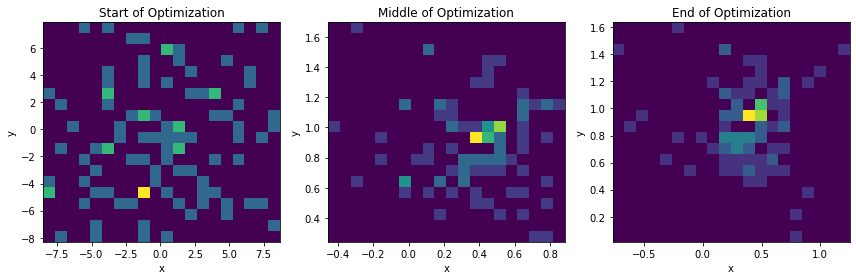

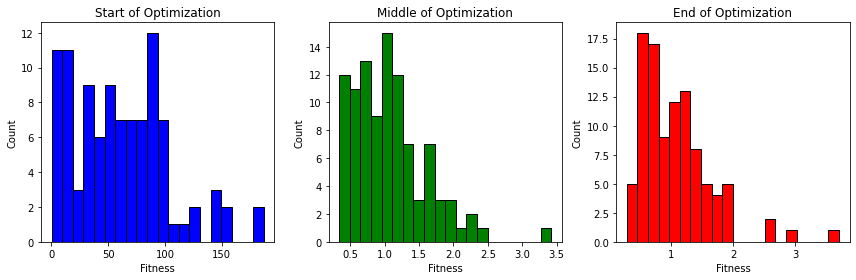

In [19]:
# 1 particle contains the values of T_peak and T_front
np.random.seed(2)

class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position # position =  parameters we want to infer
        
        self.position_cost_value = self.compute_fitness_function()
        self.best_position_cost_value = self.position_cost_value

    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)
        
        #After getting an updated position we can compute the fitness function
        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position
            self.best_position_cost_value = self.position_cost_value

    def compute_fitness_function(self):
        return float(self.position[0]**2 + self.position[1]**2)




class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.particles = []
        self.global_best_position = None
        self.global_best_position_value = None

        self.particle_positions_history = []
        self.particle_fitness_history = []

    def optimize(self, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([particle.position_cost_value for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position()
            
            self.update_global_best_position()

            if iter == 10:
                print('Particle position after iter 1')
                for particle in self.particles:
                    print(particle.position)
                    print('Best particle', self.global_best_position)

            

    def initialize_particles(self):
        self.particles = []
        for _ in range(self.num_particles):
            position = np.random.uniform(self.lower_bounds, self.upper_bounds)
            velocity = np.zeros_like(position)
            particle = Particle(position, velocity)
            self.particles.append(particle)

        index_initial_particle_lowest_cost = np.argmin([particle.position_cost_value for particle in self.particles])
        # Initialize the global best position and cost
        self.global_best_position = self.particles[index_initial_particle_lowest_cost].position
        self.global_best_position_value = self.particles[index_initial_particle_lowest_cost].position_cost_value

        print('BEst initial position:', self.global_best_position)
        print('BEst initial cost:', self.global_best_position_value)

    def update_global_best_position(self):
        for particle in self.particles:
            if particle.position_cost_value < self.global_best_position_value:
                self.global_best_position = particle.position
                self.global_best_position_value = particle.position_cost_value
                print('Global best position updated')

    def plot_particle_positions(self, frame):
        plt.cla()
        plt.plot(*zip(*self.particle_positions_history[frame]), 'go', markersize=6)
        plt.contourf(self.X, self.Y, self.Z, levels=np.linspace(0, 100, 50), cmap='viridis')
        plt.xlabel('x')
        plt.ylabel('y')

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()
    def plot_particle_history(self):
        self.particle_positions_history = np.array(self.particle_positions_history)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        # Plot histogram at the start
        ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_positions_history) // 2
        ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()


# Example usage
pso = PSO(num_particles=100, max_iterations=1000, lower_bounds=[-10, -10], upper_bounds=[10, 10])



pso.optimize()
pso.plot_particle_history()
pso.plot_particle_fitness_history()
#pso.plot_particle_positions_history()
